In [ ]:
# %pip install dgl -f https://data.dgl.ai/wheels/repo.html
# %pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html

In [1]:
import os

os.environ["DGLBACKEND"] = "pytorch"

import dgl
import dgl.nn.pytorch as dglnn
import dgl.function as fn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

plt.rcParams["figure.dpi"] = 300
sns.set_style("whitegrid")

d:\Miniconda3\envs\8007project\lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [3]:
g = torch.load("a-g.bin")
g

Graph(num_nodes={'poi': 1434, 'user': 6379},
      num_edges={('poi', 'poi_poi', 'poi'): 320, ('poi', 'poi_user', 'user'): 108312, ('user', 'user_poi', 'poi'): 108312, ('user', 'user_user', 'user'): 82808},
      metagraph=[('poi', 'poi', 'poi_poi'), ('poi', 'user', 'poi_user'), ('user', 'poi', 'user_poi'), ('user', 'user', 'user_user')])

In [4]:
def cat(tensor1, tensor2):
    return torch.cat([tensor1, tensor2], dim=1)


class GNN(nn.Module):
    def __init__(self, graph):
        super().__init__()
        u_fe = graph.nodes["user"].data["fe"].shape[1]
        p_fe = graph.nodes["poi"].data["fe"].shape[1]
        u_h1, p_h1, u_h2, p_h2 = 20, 20, 20, 20
        self.uu_conv1 = dglnn.SAGEConv(u_fe, u_h1, "mean", activation=F.leaky_relu)
        self.pp_conv1 = dglnn.SAGEConv(p_fe, p_h1, "mean", activation=F.leaky_relu)
        self.up_conv1 = dglnn.SAGEConv(
            (u_fe, p_fe), p_h2, "mean", activation=F.leaky_relu
        )
        self.pu_conv1 = dglnn.SAGEConv(
            (p_fe, u_fe), u_h2, "mean", activation=F.leaky_relu
        )
        self.uu_conv2 = dglnn.SAGEConv(u_h1 + u_h2, u_h1 + u_h2, "mean")
        self.pp_conv2 = dglnn.SAGEConv(p_h1 + p_h2, p_h1 + p_h2, "mean")
        self.up_conv2 = dglnn.SAGEConv((u_h1 + u_h2, p_h1 + p_h2), p_h1 + p_h2, "mean")
        self.pu_conv2 = dglnn.SAGEConv((p_h1 + p_h2, u_h1 + u_h2), u_h1 + u_h2, "mean")

    def forward(self, graph, predict_all=False):
        h = {
            "u": graph.nodes["user"].data["fe"],
            "p": graph.nodes["poi"].data["fe"],
            "uu": graph.edges["user_user"].data["w"],
            "pp": graph.edges["poi_poi"].data["w"],
            "up": graph.edges["user_poi"].data["w"],
        }
        u1 = self.uu_conv1(
            dgl.edge_type_subgraph(graph, ["user_user"]), h["u"], h["uu"]
        )
        p1 = self.pp_conv1(dgl.edge_type_subgraph(graph, ["poi_poi"]), h["p"], h["pp"])
        p2 = self.up_conv1(
            dgl.edge_type_subgraph(graph, ["user_poi"]), (h["u"], h["p"]), h["up"]
        )
        u2 = self.pu_conv1(
            dgl.edge_type_subgraph(graph, ["poi_user"]), (h["p"], h["u"]), h["up"]
        )
        h["u"] = cat(u1, u2)
        h["p"] = cat(p1, p2)
        u1 = self.uu_conv2(
            dgl.edge_type_subgraph(graph, ["user_user"]), h["u"], h["uu"]
        )
        p1 = self.pp_conv2(dgl.edge_type_subgraph(graph, ["poi_poi"]), h["p"], h["pp"])
        p2 = self.up_conv2(
            dgl.edge_type_subgraph(graph, ["user_poi"]), (h["u"], h["p"]), h["up"]
        )
        u2 = self.pu_conv2(
            dgl.edge_type_subgraph(graph, ["poi_user"]), (h["p"], h["u"]), h["up"]
        )
        h["u"] = cat(u1, u2)
        h["p"] = cat(p1, p2)
        with graph.local_scope():
            if predict_all:
                with torch.no_grad():
                    u = h["u"]
                    p = h["p"]
                    return torch.mm(u, p.T)
            else:
                graph.ndata["h"] = {
                    "user": h["u"],
                    "poi": h["p"],
                }
                graph.apply_edges(
                    fn.u_dot_v("h", "h", "score"), etype=("user", "user_poi", "poi")
                )
                return graph.edges["user_poi"].data["score"].squeeze(1)


def normalize(x):
    x = (x - x.min()) / (x.max() - x.min())
    return (x - x.mean()) / x.std()


def compute_loss(score, truth):
    return F.mse_loss(normalize(score), truth)

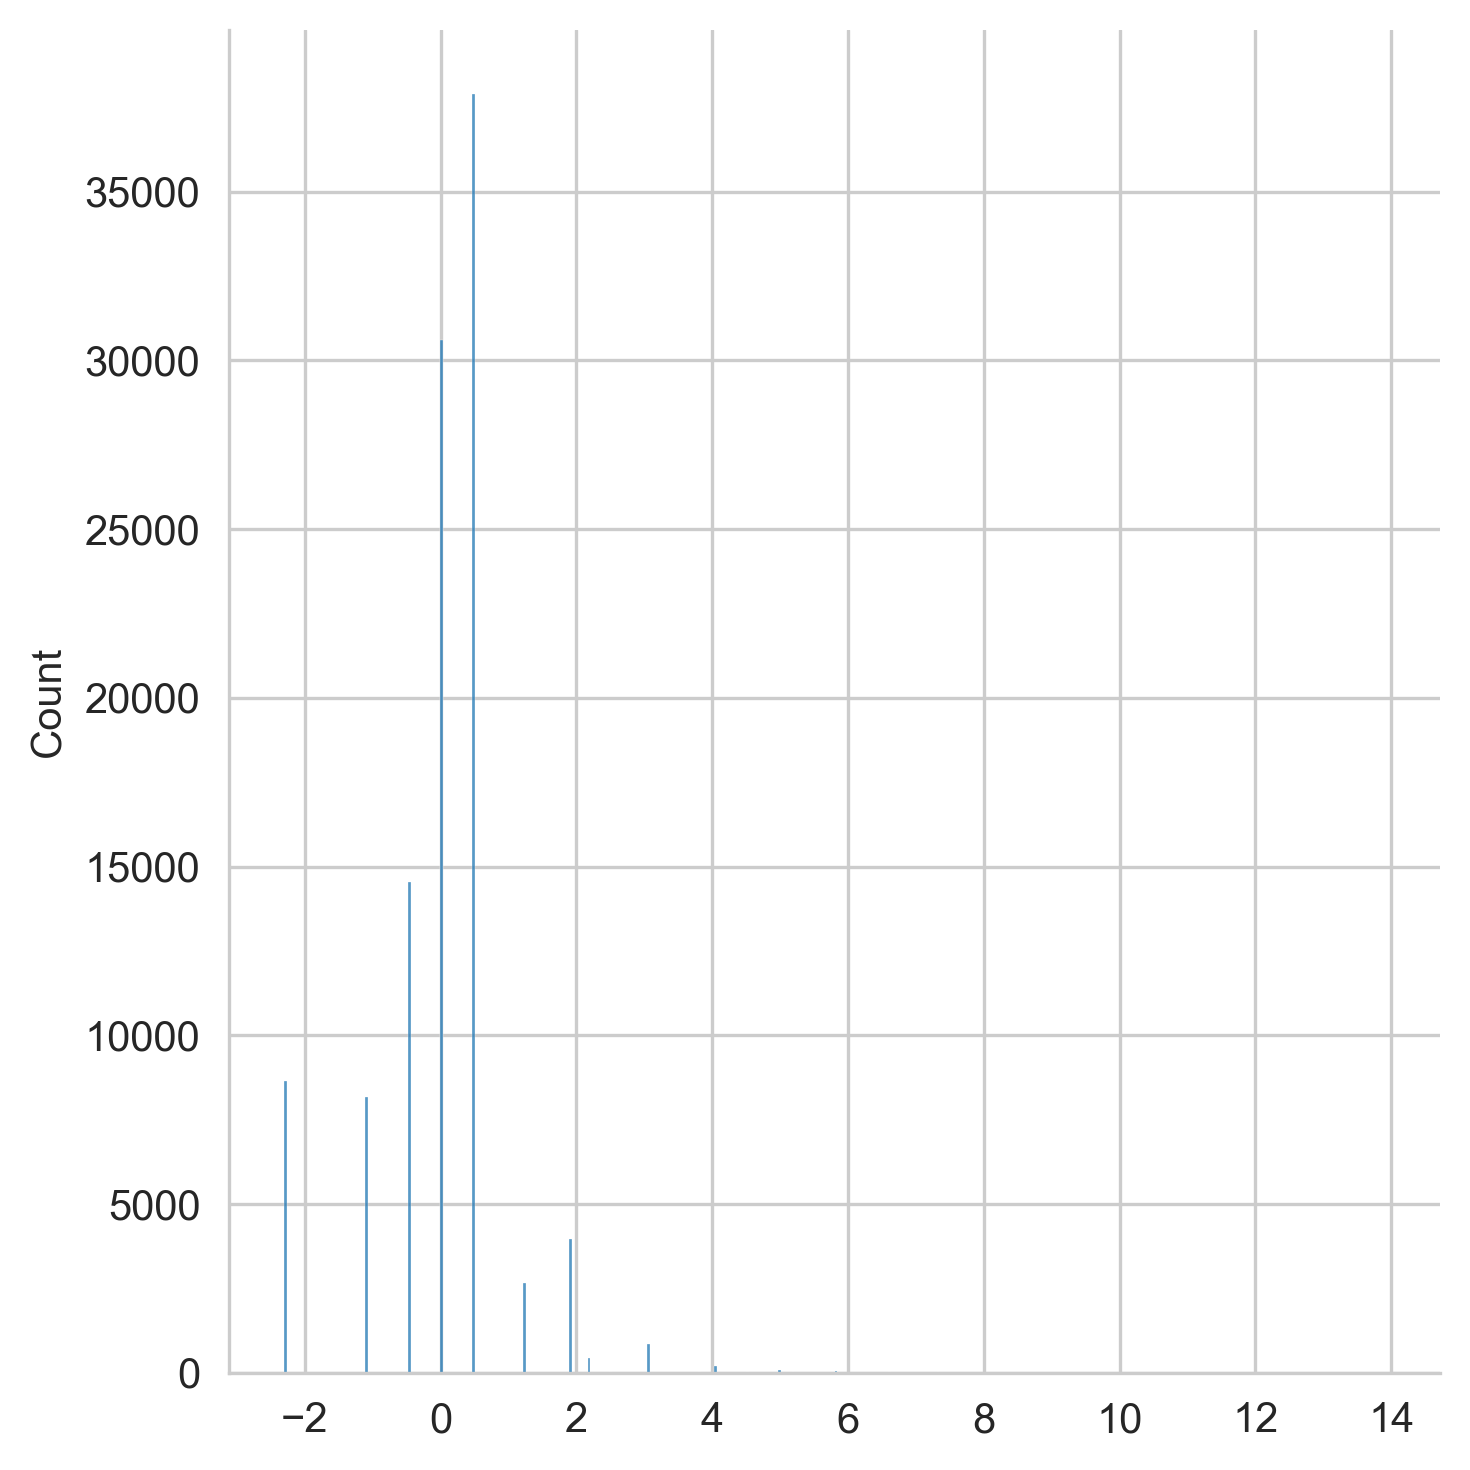

In [5]:
# def to_gaussian(t):
#     result = torch.zeros_like(t)
#     for i, x in enumerate(torch.argsort(t)):
#         result[x] = norm.ppf(0.001 + 0.998 * i / len(t))
#     return result


# def to_uniform(t):
#     result = torch.zeros_like(t)
#     for i, x in enumerate(torch.argsort(t)):
#         result[x] = i / len(t)
#     return result


# target = to_uniform(g.edges["user_poi"].data["w"])*2
target = normalize(g.edges["user_poi"].data["w"] ** 0.6)
# target = target / target.std()
sns.displot(target)

In [6]:
model = GNN(g)
epochs = 1000
opt = torch.optim.Adam(model.parameters(), lr=0.007)
losses = []

for _ in (pbar := trange(epochs)):
    score = model(g)
    loss = compute_loss(score, target)
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    pbar.set_description(f"Loss: {loss.item()}")

  0%|          | 0/1000 [00:00<?, ?it/s]/home/jerry/mambaforge/envs/w1/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
Loss: 0.4860658347606659: 100%|██████████| 1000/1000 [00:54<00:00, 18.22it/s]


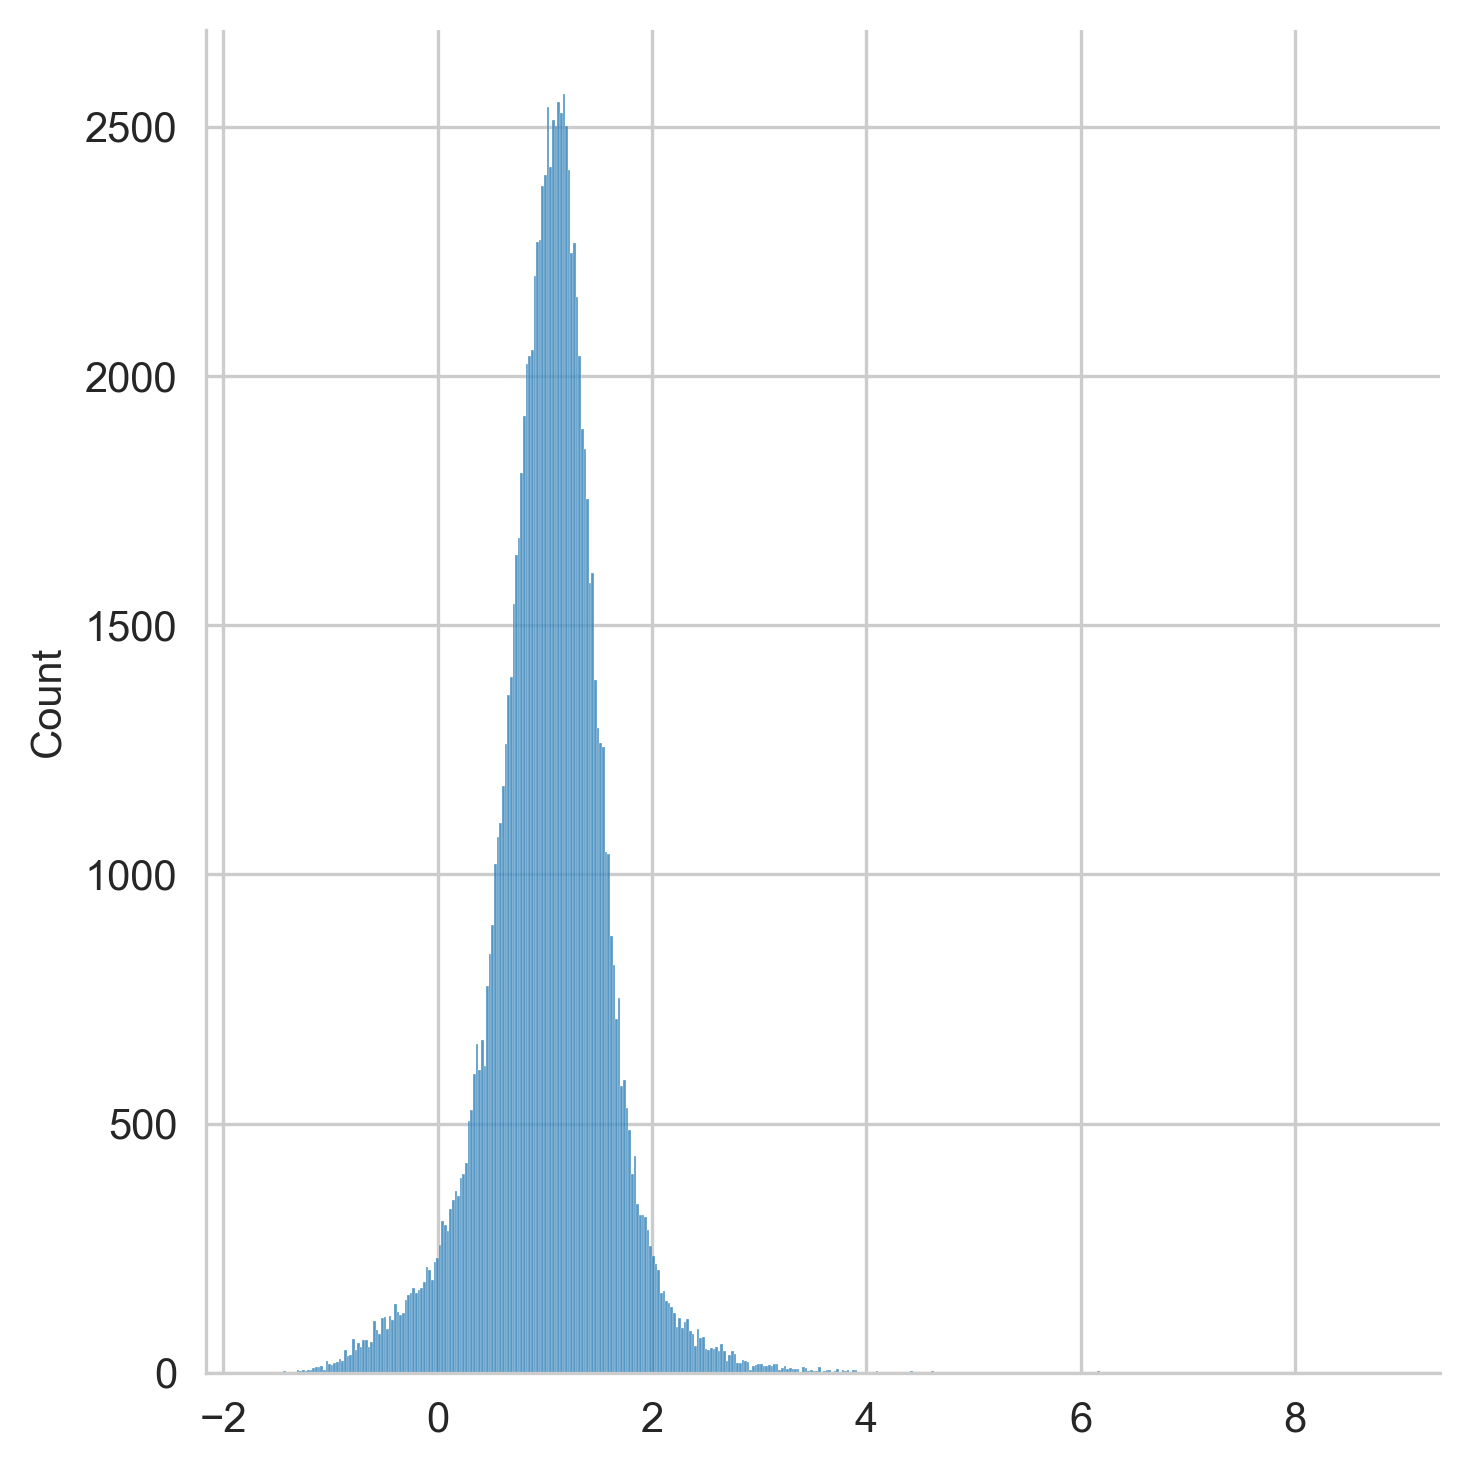

In [7]:
sns.displot(score.detach())

[None]

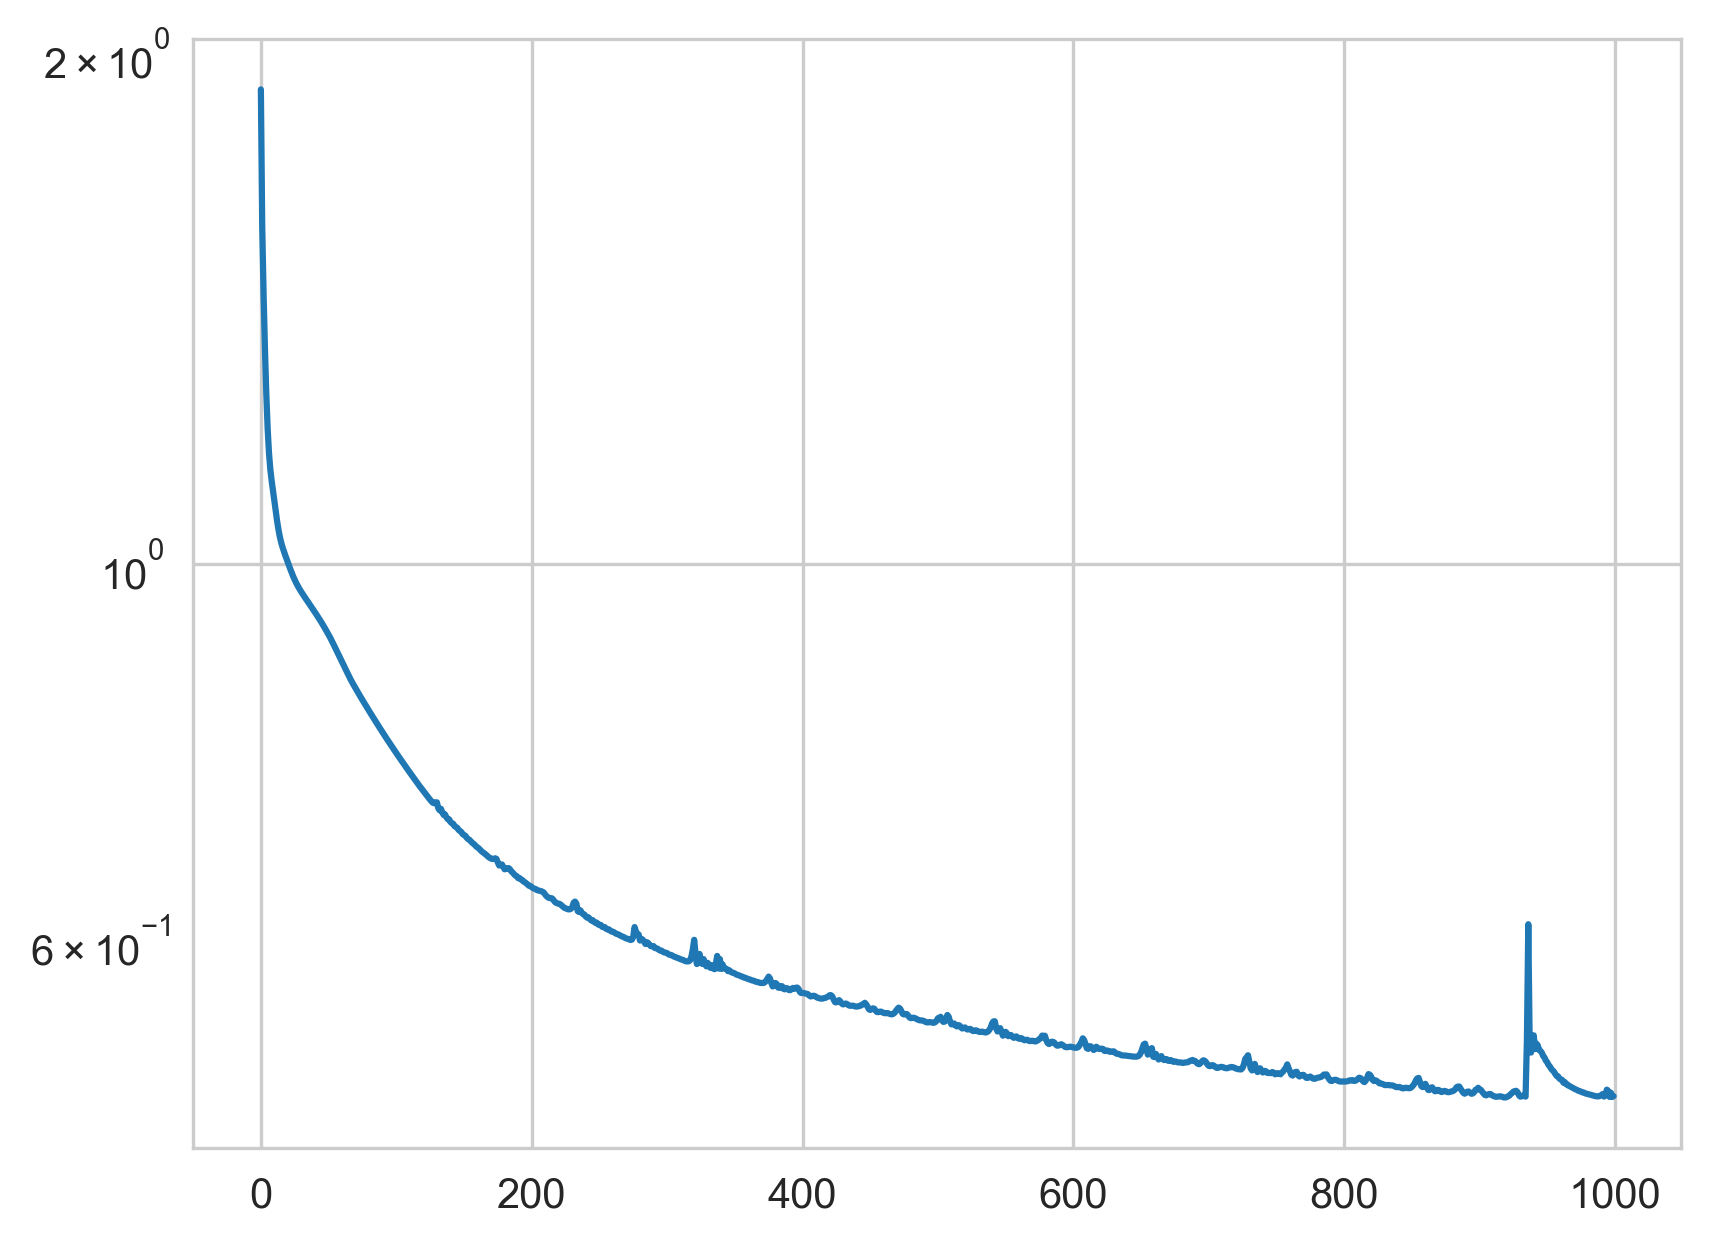

In [8]:
f = sns.lineplot(losses)
f.set(yscale="log")

In [9]:
# torch.save(model.state_dict(), "a-gnn.pt")

In [10]:
model.eval()
pred = model(g, predict_all=True)
np.save("a-pred.npy", pred.numpy())

/home/jerry/mambaforge/envs/w1/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [11]:
pred = np.argsort(pred.numpy(), axis=1)
np.unique(pred[:, -20:]).shape

(1402,)